# 🔗 Linear Regression Model

## 👽 Load and Summarize

In [38]:
# Required libraries
# import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# !pip install --upgrade pandas
import pandas as pd
# print(pd.__version__) # I am having trouble with pandas and dataframes...
import seaborn as sns
# print(sns.__version__)  # Should be 0.11.0 or higher so that `histplot() works
# !pip install --upgrade seaborn
from sklearn.feature_selection import VarianceThreshold

# Load the data
data = pd.read_csv('./data/train_data.csv')

# print(data.shape)
# data.describe()

## 🧯 Suppress the `FutureWarning`

In [39]:
# import warnings
# warnings.simplefilter("ignore", category=FutureWarning)

## 🧼 Clean the Dataset

In [40]:
# # Convert all object columns to strings
cols = ['protocol_type', 'service', 'flag', 'class']

data[cols] = data[cols].astype(str)

data = data.dropna()

# print((data['is_host_login'] == 1).count()) # 25192 empty, so I will drop
# Drop `is_host_login`

# Search for bad columns
constant_cols = [col for col in data.columns if data[col].nunique(dropna=False) == 1]
# print("Useless columns:", constant_cols)  Useless columns: ['num_outbound_cmds', 'is_host_login']
# "Let it all drop" - Modest Mouse
data = data.drop(columns=constant_cols)

# print(data.dtypes)

# Convert the label column
data['class'] = data['class'].map({'normal': 0, 'anomaly': 1})


# Get the binary columns for logistic regression
binary_cols = []

# Get the numeric clumns
numeric_cols = data.select_dtypes(include='number').columns

for col in data.select_dtypes(include='number').columns:
    unique_vals = sorted(data[col].dropna().unique())
    if unique_vals == [0, 1]:
        binary_cols.append(col)

# print("Binary columns:", binary_cols)
binary_cols.remove('num_shells')
# print(binary_cols)
# Separate the numeric and binary columns

numeric_cols = [col for col in numeric_cols if col not in binary_cols]

## 🐫 Removing Low Variance Cells

In [41]:
# Fit the selector
selector = VarianceThreshold(threshold=0.001)
selector.fit(data[numeric_cols])  # call .fit() before accessing .variances_

# Now safe to access .variances_
low_variance = [col for col, var in zip(numeric_cols, selector.variances_) if var < 0.00001]

print("Low-variance features:\n" + "-" * 100)
print(low_variance)

if low_variance:
    print("-" * 100)
    print(data[low_variance].describe())
    print("-" * 100)
    print(data.groupby('class')[low_variance].mean())
else:
    print("No low-variance features found.")

Low-variance features:
----------------------------------------------------------------------------------------------------
[]
No low-variance features found.


In [5]:
# Drop these rows because they don't help
# data = data.drop(columns=low_variance) # I am going to keep them for the moment

## 🪓 Build the Logistic Regression Model

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
X = data[binary_cols].drop(columns = 'class') # Get out of here 'class'
y = data['class']  # Tell me y, ain't nothin' but a heartbreak

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42069) # Nice

print(X)

       land  urgent  logged_in  root_shell  is_guest_login
0         0       0          0           0               0
1         0       0          0           0               0
2         0       0          0           0               0
3         0       0          1           0               0
4         0       0          1           0               0
...     ...     ...        ...         ...             ...
25187     0       0          0           0               0
25188     0       0          1           0               0
25189     0       0          0           0               0
25190     0       0          0           0               0
25191     0       0          0           0               0

[25192 rows x 5 columns]


### 🚂 Train the Model

In [61]:
model = LogisticRegression(class_weight='balanced') # Because my `rofp` is not great right now
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

### 🐊 Evaluate the Model

In [85]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, r2_score

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluation
print("ROC AUC (Test):", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

print("-" * 100)
print("Train classification report:")
print(classification_report(y_train, y_pred_train))

print("-" * 100)
print("Test classification report:")
print(classification_report(y_test, y_pred_test))


ROC AUC (Test): 0.8344865925710252
----------------------------------------------------------------------------------------------------
Train classification report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     10783
           1       0.74      0.97      0.84      9370

    accuracy                           0.83     20153
   macro avg       0.85      0.84      0.83     20153
weighted avg       0.86      0.83      0.83     20153

----------------------------------------------------------------------------------------------------
Test classification report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      2666
           1       0.74      0.96      0.84      2373

    accuracy                           0.82      5039
   macro avg       0.85      0.83      0.82      5039
weighted avg       0.85      0.82      0.82      5039



### 🦖 Confusion Matrix

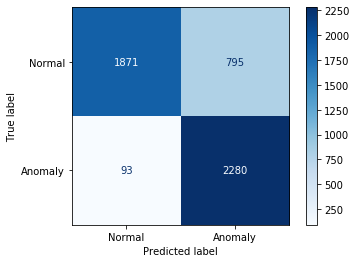

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Normal', 'Anomaly']
)

# Plot it
disp.plot(cmap='Blues')

### 🔌 Adjust Decision Threshold

Text(0.5, 1.0, 'Precision vs. Recall')

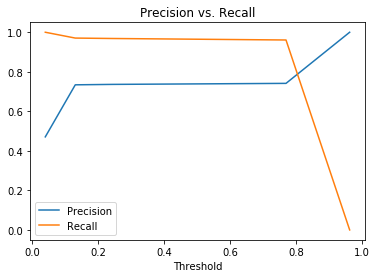

In [87]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

probs = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
threshold = 0.6  # Start tuning this up from 0.5
y_pred_adjusted = (probs >= threshold).astype(int)

precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold"); plt.legend(); plt.title("Precision vs. Recall")

### 🍳 Compute F-Score per Threshold

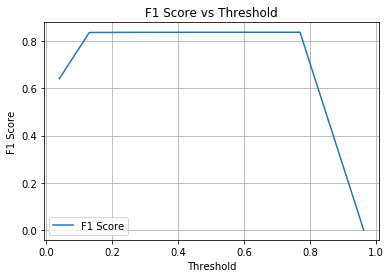

In [88]:
from sklearn.metrics import f1_score

f1_scores = [f1_score(y_test, (probs >= t).astype(int)) for t in thresholds]

plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

### 🦉 Adjust the Threshold Accordingly

In [89]:
import numpy as np

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1:.3f}")

Best Threshold: 0.769
Best F1 Score: 0.837


In [90]:
y_pred_test_2 = (probs >= best_threshold).astype(int)

### 🐊 Re-Evaluate the Model

In [96]:
print("Classification report (optimal threshold):")
print(classification_report(y_test, y_pred_test_2))

Classification report (optimal threshold):
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      2666
           1       0.74      0.96      0.84      2373

    accuracy                           0.82      5039
   macro avg       0.85      0.83      0.82      5039
weighted avg       0.85      0.82      0.82      5039



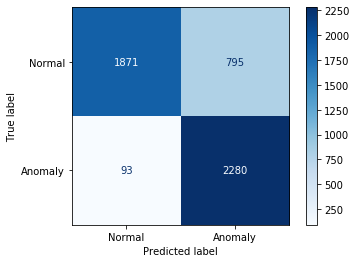

In [97]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test_2)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Normal', 'Anomaly']
)

# Plot it
disp.plot(cmap='Blues')